<a href="https://colab.research.google.com/github/Alenush/dish_id_sirius/blob/Team-1/chefnet_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных

In [ ]:
!pip install gdown

### Загрузка картинок

In [ ]:
!gdown https://drive.google.com/uc?id=1rN0yvtlHkDbhHWRjp104FQuCyl9BAZuC
!unzip -qq AllRecipes_images.zip 
!rm AllRecipes_images.zip

Downloading...
From: https://drive.google.com/uc?id=1rN0yvtlHkDbhHWRjp104FQuCyl9BAZuC
To: /content/AllRecipes_images.zip
3.70GB [00:54, 67.5MB/s]


In [ ]:
import os
import shutil
import random

In [ ]:
!mkdir ./AllRecipes_images/train
!mkdir ./AllRecipes_images/val

In [ ]:
imgs = [file for file in os.listdir('AllRecipes_images/') if file[-3:]=='jpg']

for img in imgs:
  shutil.move(os.path.join('AllRecipes_images', img), 'AllRecipes_images/train')

In [ ]:
val_proportion = 0.2
val_imgs = random.sample(imgs, int(val_proportion * len(imgs)))
for img in val_imgs:
  shutil.move(os.path.join('AllRecipes_images/train', img), 'AllRecipes_images/val')

In [ ]:
print(f"Train amount - {len(os.listdir('AllRecipes_images/train'))}")
print(f"Val amount - {len(os.listdir('AllRecipes_images/val'))}")

Train amount - 149638
Val amount - 37409


### Загрузка ингредиентов блюд

In [ ]:
!gdown https://drive.google.com/uc?id=1rNb_CqMtA0lx-JzOxWhyM204SGQ0s5qJ
!mkdir AllRecipes_ingred
!unzip -qq db.zip -d AllRecipes_ingred
!rm db.zip

Downloading...
From: https://drive.google.com/uc?id=1rNb_CqMtA0lx-JzOxWhyM204SGQ0s5qJ
To: /content/db.zip
13.5MB [00:00, 212MB/s]


### MongoDB

In [ ]:
!python -m pip install pymongo==3.7.2
!apt install mongodb

In [ ]:
!mongod --dbpath AllRecipes_ingred/db --fork --logpath /var/log/mongod.log

about to fork child process, waiting until server is ready for connections.
forked process: 699
child process started successfully, parent exiting


In [ ]:
from pymongo import MongoClient
from bson import json_util
import json

In [ ]:
db_client = MongoClient('localhost', 27017)
recipe_db = db_client['allrecipes']['recipe_data']
recipe_list = list(recipe_db.find())
print(f"Всего блюд - {len(recipe_list)}")

for recipe in recipe_list:
  if '_id' in recipe:
    del recipe['_id']

with open('recipes_raw.json', 'w') as f:
  f.write(json.dumps(recipe_list, indent=2))

Всего блюд - 31233


## Preprocessing

In [ ]:
from PIL import Image
from tqdm.notebook import tqdm
import os
import json

Проверка на битые картинки

In [ ]:
path_to_img = 'AllRecipes_images/'
img_size = (250, 250)

bad_imgs_count = 0
for file_name in tqdm(os.listdir(path_to_img), desc='Checking images'):
  img = Image.open(path_to_img + file_name).convert('RGB')
  if img.size != img_size:
    print(f'Image {file_name} size - {img.size}')
    bad_imgs_count += 1

print(f'Total bad images found = {bad_imgs_count}')

Удаление дубликатов рецептов

In [ ]:
unique_ids = set()

tmp = []
for recipe in recipe_list:
  if recipe['id'] not in unique_ids:
    tmp.append(recipe)
    unique_ids.add(recipe['id'])

recipe_list = tmp
print((f'Рецептов после удаления дубликатов - {len(recipe_list)}'))

Рецептов после удаления дубликатов - 27827


In [ ]:
with open('recipes_raw.json', 'w') as f:
  f.write(json.dumps(recipe_list))

Препроцессинг ингредиентов

In [76]:
with open('recipes_raw.json', 'rb') as f:
  recipe_list = json.loads(f.read())

In [77]:
import html
from html.parser import HTMLParser
import re
import unicodedata

REPLACEMENTS = {
    u'\x91':"'", u'\x92':"'", u'\x93':'"', u'\x94':'"', u'\xa9':'',
    u'\xba': ' degrees ', u'\xbc':' 1/4', u'\xbd':' 1/2', u'\xbe':' 3/4',
    u'\xd7':'x', u'\xae': '',
    '\\u00bd':' 1/2', '\\u00bc':' 1/4', '\\u00be':' 3/4',
    u'\\u2153':' 1/3', '\\u00bd':' 1/2', '\\u00bc':' 1/4', '\\u00be':' 3/4',
    '\\u2154':' 2/3', '\\u215b':' 1/8', '\\u215c':' 3/8', '\\u215d':' 5/8',
    '\\u215e':' 7/8', '\\u2155':' 1/5', '\\u2156':' 2/5', '\\u2157':' 3/5',
    '\\u2158':' 4/5', '\\u2159':' 1/6', '\\u215a':' 5/6', '\\u2014':'-',
    '\\u0131':'1', '\\u2122':'', '\\u2019':"'", '\\u2013':'-', '\\u2044':'/',
    '\\u201c':'\\"', '\\u2018':"'", '\\u201d':'\\"', '\\u2033': '\\"',
    '\\u2026': '...', '\\u2022': '', '\\u2028': ' ', '\\u02da': ' degrees ',
    '\\uf04a': '', u'\xb0': ' degrees ', '\\u0301': '', '\\u2070': ' degrees ',
    '\\u0302': '', '\\uf0b0': ''
}

parser = HTMLParser()
def prepro_txt(text):
    import urllib

    text = html.unescape(text)

    for unichar, replacement in REPLACEMENTS.items():
      if unichar in text:
        text = text.replace(unichar, replacement)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')

    try:
        text = urllib.parse.unquote(text.decode('ascii'))
    except UnicodeDecodeError:
        pass # if there's an errant %, unquoting will yield an invalid char

    # some extra tokenization
    text = ' - '.join(text.split('-'))
    text = ' & '.join(text.split('&'))

    text = re.sub(r'\\[nt]', ' ', text) # remove over-escaped line breaks and tabs
    text = re.sub(r'\b([^\d\s]+)/(.*)\b', r'\1 / \2', text) # split non-fractions
    text = re.sub(r'\b(.*)/([^\d\s]+)\b', r'\1 / \2', text) # e.g. 350 deg/gas mark
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace

    return text.strip()

In [78]:
for recipe in tqdm(recipe_list, desc='Preprocess ingredients'):
  ingred_list = recipe['ingred_list']
  new_ingred_list = []
  for ingred in ingred_list:
    new_ingred_list.append(prepro_txt(ingred))
  recipe['ingred_list'] = new_ingred_list

In [79]:
from string import ascii_lowercase
def replace_units(s):
  tokens = s.replace('to taste', '').split()
  units = ['ounce', 'ounces', 'cups', 'cup', 'teaspoon', 'tablespoon', 'tablespoons', 'teaspoons', 
           'c', 'g', 'v', 'tbsp', 'x', 'ml', 'lb', 'tbs', 'oz', 'pkg', 'large', 'small', 'tsp', 'inch', 
           'grams', 'quarts', 'lbs', 'can', 'cube', 'whole', 'or', 'pieces', 'piece', 'chopped', 
           'shredded', 'diced', 'fresh', 'crushed', 'minced']
  tokens_new = []
  for t in tokens:
      if t not in units:
          tokens_new.append(t)
  
  return ' '.join(tokens_new)

def cleanup_ingredient_list(l):
    l = [replace_units(''.join([char for char in x.lower() if char in ascii_lowercase + ' ']).strip()) for x in l]
    return l

In [80]:
for recipe in tqdm(recipe_list, desc='Preprocess ingredients'):
  recipe['ingred_list'] = cleanup_ingredient_list(recipe['ingred_list'])

In [66]:
import csv
import re
from collections import Counter
from itertools import permutations as permut

clean_ingredients - эталонный список ингредиентов

In [ ]:
# clean_ingredients = set()

# with open('nndb_flat.csv', 'r') as f:
#   reader = csv.reader(f)
#   next(reader)
#   for row in tqdm(reader):
#     row = row[3].lower()
#     row = re.sub(r'\([^)]*\)', '', row)
#     row = re.split(r',\s', row)
#     row = [item.strip() for item in row]
#     trigrams = []
#     for bigram in permut(row[:0:-1], 2):
#       trigram = re.sub(r',', '', ' '.join([*bigram, row[0]])).strip()
#       trigrams.append(trigram)
#     bigrams = []
#     for unigram in row[:0:-1]:
#       bigram = re.sub(r',', '', ' '.join([unigram, row[0]])).strip()
#       bigrams.append(bigram)
#     candidates = [*trigrams, *bigrams, row[0]]

#     clean_ingredients.update(candidates)

# clean_ingredients = list(clean_ingredients)

In [81]:
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = set(f.read().split('\n'))

In [82]:
len(clean_ingredients)

208

In [83]:
import inflect
engine = inflect.engine()

def clean_ingredient_list(l, clean_ingredients):
    recipe = []
    for ingr in l:
      ingr = ingr.split()
      ingr_found = False
      for trigram in permut(ingr, 3):
        trigram = ' '.join(trigram)
        if trigram in clean_ingredients:
          recipe.append(trigram)
          ingr_found = True
          break
      if ingr_found:
        continue
      for bigram in permut(ingr, 2):
        bigram = ' '.join(bigram)
        if bigram in clean_ingredients:
          recipe.append(bigram)
          ingr_found = True
          break
        plural = engine.plural(bigram)
        if plural in clean_ingredients:
          recipe.append(plural)
          ingr_found = True
          break
      if ingr_found:
        continue
      for unigram in ingr:
        if unigram in clean_ingredients:
          recipe.append(unigram)
          break
        plural = engine.plural(unigram)
        if plural in clean_ingredients:
          recipe.append(plural)
          break

    return list(set(recipe))

In [84]:
for recipe in tqdm(recipe_list):
  recipe['ingred_list'] = clean_ingredient_list(recipe['ingred_list'], clean_ingredients)

In [105]:
empty_recipes_count = 0 
for recipe in recipe_list:
  if len(recipe['ingred_list']) == 0:
    empty_recipes_count += 1

print(f'Рецептов с пустым списком ингред-ов - {empty_recipes_count}')

Рецептов с пустым списком ингред-ов - 0


In [107]:
from random import randint
recipe_list[randint(0, len(recipe_list) - 1)]

{'id': '9370',
 'ingred_list': ['bread', 'water', 'onion', 'salt', 'poultry', 'black pepper'],
 'item_name': 'Really Easy Bread Stuffing'}

In [86]:
recipe_list = [recipe for recipe in recipe_list if len(recipe['ingred_list']) > 0]

with open('recipes.json', 'w') as f:
  f.write(json.dumps(recipe_list, indent=2))

In [18]:
all_ingred = []

for recipe in tqdm(recipe_list):
    all_ingred.extend(recipe['ingred_list'])

print(f'Found {len(set(all_ingred))} unique ingredients in dataset of all recipes') 
        
# clean_ingredients = list([i for i, n in c.most_common()][:select_top_n_ingredients])


Found 195 unique ingredients in dataset of all recipes


In [19]:
from collections import Counter
c = Counter(all_ingred)
print('Most popular ingredients:')
c.most_common(20)

Most popular ingredients:


[('salt', 13269),
 ('sugar', 10310),
 ('onion', 9424),
 ('butter', 9041),
 ('egg', 8149),
 ('flour', 7399),
 ('cheese', 7202),
 ('black pepper', 6484),
 ('water', 5804),
 ('clove', 5399),
 ('milk', 5294),
 ('olive oil', 4784),
 ('chicken', 4644),
 ('vanilla', 4202),
 ('pepper', 3415),
 ('vegetable oil', 3254),
 ('sauce', 3182),
 ('lemon', 3114),
 ('cinnamon', 2696),
 ('beef', 2379)]

## Обучение

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [29]:
with open('recipes.json', 'rb') as f:
  recipe_list = json.loads(f.read())
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = set(f.read().split('\n'))

In [30]:
id2word = defaultdict()
id2word[0] = '<pad>'
id2word[1] = '<start>'
id2word[2] = '<end>'
for i, ingr in enumerate(clean_ingredients):
  id2word[i+3] = ingr

word2id = {v:k for k,v in id2word.items()}

In [31]:
def ids2words(word_ids):
  result = []
  for id in word_ids:
    word = id2word[id]
    if word == '<start>':
      continue
    elif word == '<end>':
      break
    else:
      result.append(word)
  return result

def words2ids(words):
  return [word2id[word] for word in words]

In [32]:
class RecipesDataset(Dataset):
  def __init__(self, recipes_json, img_folder, transform=None):
    super().__init__()

    with open(recipes_json, 'r') as f:
      recipes = json.load(f)
    self.recipes = defaultdict(dict)
    for recipe in recipes:
      recipe['ingred_list'].insert(0, '<start>')
      recipe['ingred_list'].append('<end>')
      self.recipes[recipe['id']] = recipe

    self.img_folder = img_folder
    self.imgs = os.listdir(self.img_folder)
    self.imgs = [img for img in self.imgs if img.split('_')[0] in self.recipes]
    
    self.transform = transform

  def __getitem__(self, index):
    img_name = self.imgs[index]
    img = Image.open(self.img_folder + img_name).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    
    recipe_id = img_name.split('_')[0]
    ingred_list = self.recipes[recipe_id]['ingred_list']
    return img, torch.LongTensor(words2ids(ingred_list))

  def __len__(self):
    return len(self.imgs)

In [33]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(data):
  # отсортируем по длине описания
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)
  
  # составим 4D тензор изображений из кортежа 3D тензоров
  # images: (batch_size, channels(rgb), width, height)
  images = torch.stack(images, 0)

  # составим 2D тензор описаний из кортежа 1D тензоров
  # дополним каждое описание символом <pad> так, чтобы у всех описаний совпадали длины
  lengths = [len(cap) for cap in captions]
  targets = torch.LongTensor(np.zeros((len(captions), max(lengths))))
  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]  

  return images, targets, lengths

In [57]:
class Encoder(nn.Module):
  def __init__(self, encoder, encod_size, finetune=False):
    super().__init__()
    
    self.finetune = finetune
    if not self.finetune:
      for param in encoder.parameters():
        param.requires_grad = False

    modules = list(encoder.children())[:-1]
    self.encoder = nn.Sequential(*modules)
  
  def finetune_active(self, activate):
    if activate:
      self.finetune = True
      for param in self.encoder.parameters():
        param.requires_grad = True
    else:
      self.finetune = False
      for param in self.encoder.parameters():
        param.requires_grad = False
  
  def forward(self, images):
    if not self.finetune:  
      with torch.no_grad():
        features = self.encoder(images)
    else:
        features = self.encoder(images)

    features = features.view(features.size(0), -1)
    return features

In [35]:
class Decoder(nn.Module):
    def __init__(self, encod_size, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0):
      super().__init__()
      self.encod_feat = nn.Linear(encod_size, embed_size)
      self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
      self.embedding = nn.Embedding(vocab_size, embed_size)
      self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True,
                         dropout=dropout)
      self.linear = nn.Linear(hidden_size, vocab_size)
  
    # обучение, используются истинные описания
    def forward(self, features, captions, lengths):
      embed = self.embedding(captions)
      features = self.encod_feat(features)
      features = self.bn(features)
      embed = torch.cat((features.unsqueeze(1), embed), 1)
      packed = pack_padded_sequence(embed, lengths, batch_first=True)
      outputs, _ = self.rnn(packed)
      outputs = self.linear(outputs[0])
      return outputs

    # проверка, истинные описания не используются
    def sample(self, features, max_len, states=None):
      id_preds = list()
      features = self.encod_feat(features)
      features = self.bn(features)
      inputs = features.unsqueeze(1)
      for i in range(max_len):
        rnn_outputs, states = self.rnn(inputs, states)
        lin_outputs = self.linear(rnn_outputs.squeeze(1))
        _, pred_id = lin_outputs.max(1)
        id_preds.append(pred_id)
        inputs = self.embedding(pred_id).unsqueeze(1)
      id_preds = torch.stack(id_preds, 1)
      return id_preds

In [80]:
from random import randint

val_images = os.listdir('AllRecipes_images/val')

def predict_val_image():
  with torch.no_grad():
    img_name = val_images[randint(0, len(val_images)-1)]
    recipe_id = img_name.split('_')[0]
    img = Image.open(os.path.join('AllRecipes_images/val', img_name))
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform(img).to(device).unsqueeze(0)
    ingred_pred = ids2words(decoder.sample(encoder(img), 30)[0].cpu().numpy())

    dish_name = train_data.recipes[recipe_id]['item_name']
    ingred_real = train_data.recipes[recipe_id]['ingred_list']
    print(dish_name, end='\n\n')
    print('Real:')
    print('\t' + '\n\t'.join(ingred_real[1:-1]), end='\n\n')
    print('Prediction:')
    print('\t' + '\n\t'.join(ingred_pred))

In [54]:
def train(encoder, decoder, criterion, optimizer, num_epochs,
          epoch_losses, log_step=100, start_epoch=1):

  batch_losses = defaultdict(list)
  for epoch in range(start_epoch, num_epochs + start_epoch):
    # режим обучения

    print(f'Эпоха {epoch}')

    running_loss = 0.0
    
    i = 1
    for images, tokens, lengths in tqdm(train_loader, desc=f'Обучение'):
      # Перенесем изобр-я и описания на GPU, составим вектор истинных описаний
      images = images.to(device)
      tokens = tokens.to(device)
      targets = pack_padded_sequence(tokens, lengths, batch_first=True)[0]

      # Проведем изобр-я через модель, получим описания (в виде векторов id), сгенерир. моделью
      features = encoder(images)
      outputs = decoder(features, tokens[:, :-1], lengths)
      
      # посчитать лосс на батче
      loss = criterion(outputs, targets)
      
      # посчитать градиенты
      loss.backward()
      
      # обновить параметры модели
      optimizer.step()
      
      # обнулить градиенты
      optimizer.zero_grad()

      running_loss += loss.item()

      if i % log_step == 0:
        encoder.eval()
        decoder.eval()
        predict_val_image()
        encoder.train()
        decoder.train()

      i+=1

    if encoder.finetune:
      torch.save(decoder.state_dict(), f'weights/enc_{epoch}_epoch.pth')

    torch.save(decoder.state_dict(), f'weights/dec_{epoch}_epoch.pth')
    

    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch} train loss:\t{train_loss:.4f}')
    epoch_losses['train_nll'].append(train_loss)

In [38]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = RecipesDataset('recipes.json', 'AllRecipes_images/train/', transform)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)

In [42]:
encoder = Encoder(models.resnet101(pretrained=True), encod_size=2048, 
                  finetune=False).to(device)
decoder = Decoder(2048, 512, 512, len(word2id), dropout=0.5).to(device)

In [43]:
for p in decoder.rnn.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

criterion = nn.CrossEntropyLoss()
torch.manual_seed(42)
optimizer = optim.Adam(params=decoder.parameters(), lr=1e-3)

In [ ]:
encoder.train()
decoder.train()

epoch_losses = defaultdict(list)

torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
train(encoder, decoder, criterion, optimizer, num_epochs=25, epoch_losses=epoch_losses,
      log_step=250)

In [60]:
decoder.load_state_dict(torch.load('weights/25_epoch.pth'))

<All keys matched successfully>

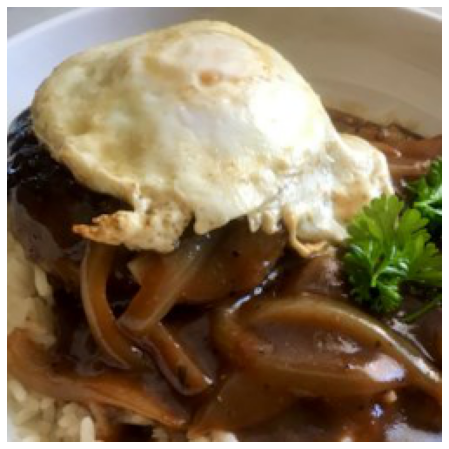

Hawaiian Loco Moco

Real:
	water
	onion
	egg
	mushrooms
	beef
	rice

Prediction:
	water
	onion
	olive oil
	chicken
	mushrooms
	fish
	bean
	salt
	clove


In [91]:
encoder.eval()
decoder.eval()
predict_val_image()

Эпоха 25


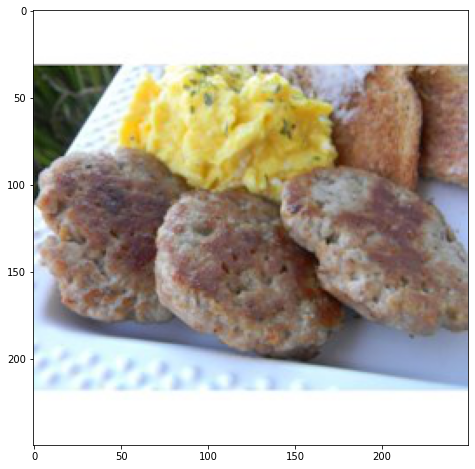

Grampa's Coriander Turkey Sausage:

Real:
sugar
pepper
turkey
olive oil
salt
black pepper

Prediction:
sugar
egg
baking powder
butter
flour
salt
vanilla


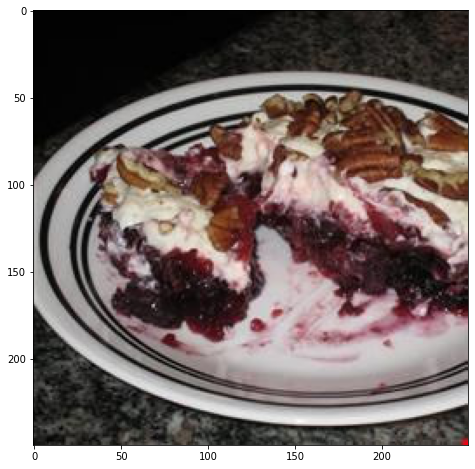

Blueberry Salad:

Real:
water
sugar
sour cream
pineapple
vanilla
cheese

Prediction:
water
sugar
egg
butter
chocolate
flour
salt
vanilla


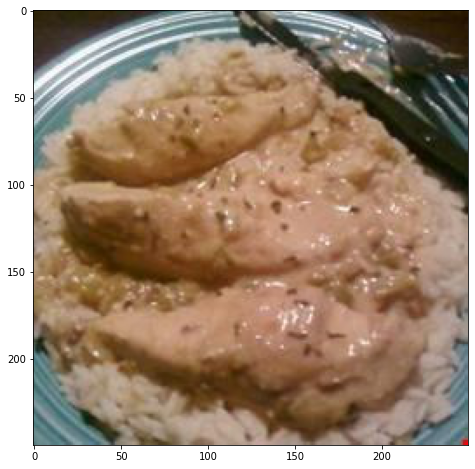

Chicken Creole with Chile Cream Sauce:

Real:
water
olive oil
chicken
sour cream
lime
rice

Prediction:
water
onion
olive oil
chicken
mushrooms
salt
shrimp
clove


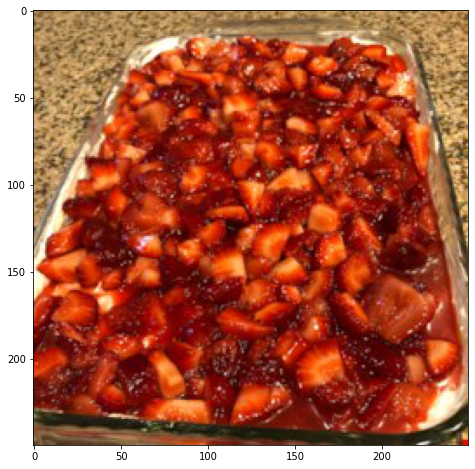

Strawberry Angel Food Dessert:

Real:
sugar
cheese

Prediction:
water
sugar

Epoch 25 train loss:	1.2944
Эпоха 26


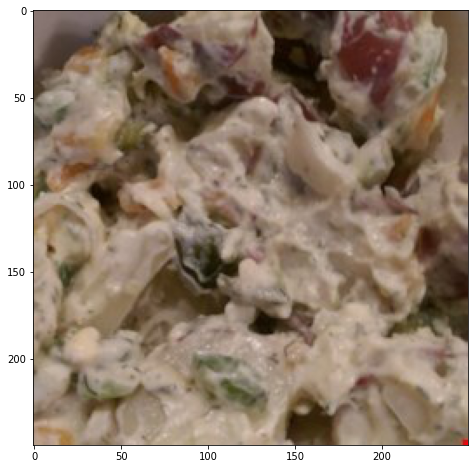

Red Potato Salad:

Real:
onion
garlic powder
egg
sour cream
mustard
dill
celery
salt
sauce
vinegar
mayonnaise

Prediction:
onion
egg
celery
salt
vinegar
mayonnaise
milk
black pepper


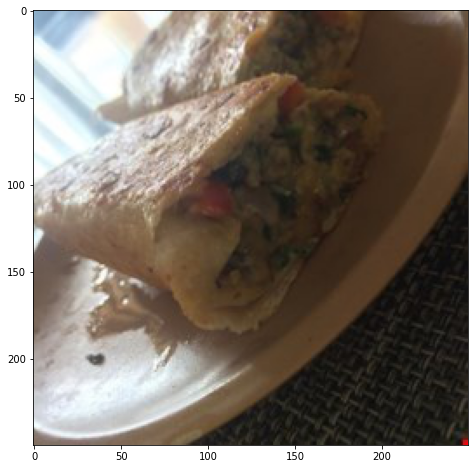

Toasted Breakfast Burritos:

Real:
water
turkey
egg
butter
vegetables
tortilla
cheese

Prediction:
bread
onion
egg
olive oil
basil
dried oregano
sausage
cheese


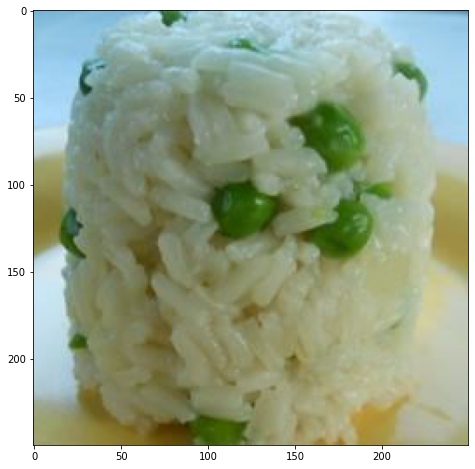

Chickeny Chickeny Rice:

Real:
water
onion
olive oil
chicken
butter
salt
rice

Prediction:
water
salt
butter
rice


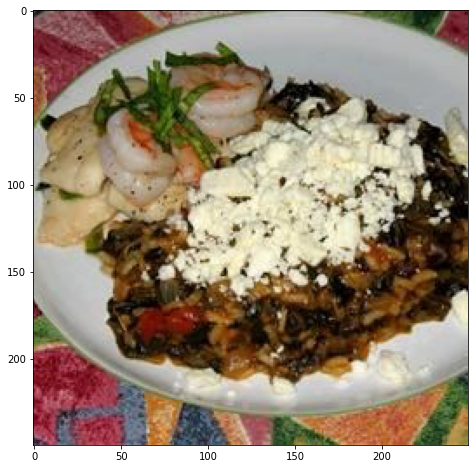

Classic Greek Spinach:

Real:
water
onion
olive oil
beef
salt
rice
tomato
spinach
clove

Prediction:
bread
onion
egg
olive oil
jalapeno
plum
paprika
green pepper
clove

Epoch 26 train loss:	1.3106
Эпоха 27


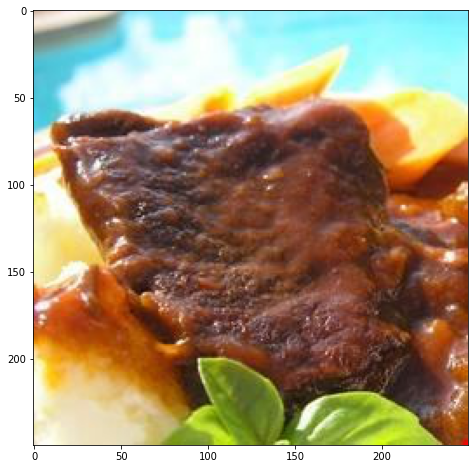

Barbeque Style Braised Short Ribs:

Real:
onion
beef
salt
clove
vegetable oil
sauce
tomato
black pepper
carrot

Prediction:
sugar
pepper
onion
chicken
wine
mustard
salt
vegetable oil
black pepper
clove


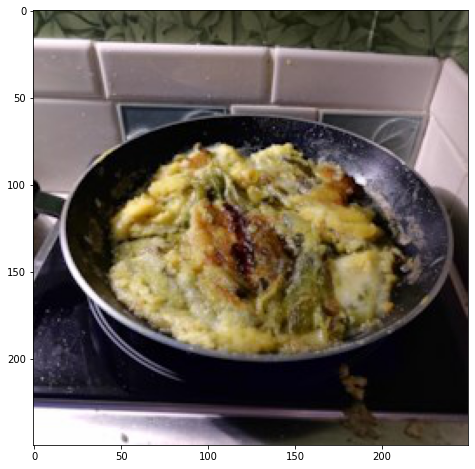

Authentic Mexican Chili Rellenos:

Real:
pepper
egg
baking powder
vegetables
flour
cheese

Prediction:
onion
egg
olive oil
salt
parsley
ham
red pepper


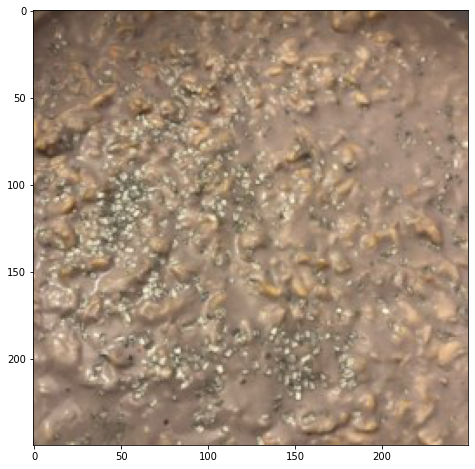

Overnight Refrigerator Oatmeal:

Real:
almond
yogurt
banana

Prediction:
milk
butter
chocolate


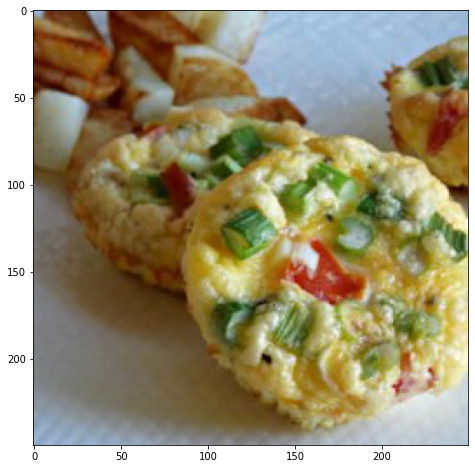

Tomatoes and Bacon Egg Muffins:

Real:
egg
black pepper
bacon
onion

Prediction:
onion
egg
avocado
salt
black pepper

Epoch 27 train loss:	1.3190
Эпоха 28


KeyboardInterrupt: ignored

In [59]:
encoder.train()
decoder.train()

#encoder.finetune_active(True)
#batch_size = 32
batch_size = 256

train(encoder, decoder, criterion, optimizer, num_epochs=25, epoch_losses=epoch_losses,
      log_step=250, start_epoch=26)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epoch_losses['train_nll'])
plt.title('Training loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.show()

Посмотрим на результат

In [ ]:
decoder.load_state_dict(torch.load(f'weights/20_epoch.pth'))

<All keys matched successfully>